In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
# %qtconsole

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

from dask.distributed import Client, LocalCluster
import dask
import logging

logging.basicConfig(level=logging.INFO)

client = Client(processes=True)

client

Client Scheduler: tcp://127.0.0.1:51877 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 17.18 GB


In [3]:
from src.load_data import load_data

epoch_key = ('bon', 3, 2)

data = load_data(epoch_key)

INFO:src.load_data:Finding ripple times...


In [4]:
from replay_trajectory_classification import ClusterlessClassifier
from replay_trajectory_classification.state_transition import estimate_movement_var
from src.parameters import SAMPLING_FREQUENCY
from dask.diagnostics import ProgressBar
from replay_trajectory_classification.misc import NumbaKDE

position = data['position_info'].loc[:, ['x_position', 'y_position']]
is_training = data['position_info'].speed > 4
ripple_times = data['ripple_times'].loc[:, ['start_time', 'end_time']]

movement_var = np.diag(
    estimate_movement_var(position, SAMPLING_FREQUENCY)).max()

model_kwargs = {
    'bandwidth': np.array([24.0, 24.0, 24.0, 24.0, 6.0, 6.0])}
classifier = ClusterlessClassifier(
    place_bin_size=2.0,
    movement_var=2.0,
    replay_speed=1,
    discrete_transition_diag=1-1E-3,
    model=NumbaKDE,
    model_kwargs=model_kwargs).fit(
    position, data['multiunit'], is_training=is_training)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting multiunits...


In [5]:
from src.analysis import reshape_to_segments

ripple_position = reshape_to_segments(
    data['position_info'].loc[:, ['x_position', 'y_position']],
    data['ripple_times'].loc[:, ['start_time', 'end_time']])

In [ ]:
ripple_number = 145

time_slice = slice(data['ripple_times'].loc[ripple_number, 'start_time'],
                   data['ripple_times'].loc[ripple_number, 'end_time'])
m = data['multiunit'].sel(time=time_slice)
result = classifier.predict(m, m.time - m.time[0])

In [ ]:
%time classifier.predict(m, m.time - m.time[0])

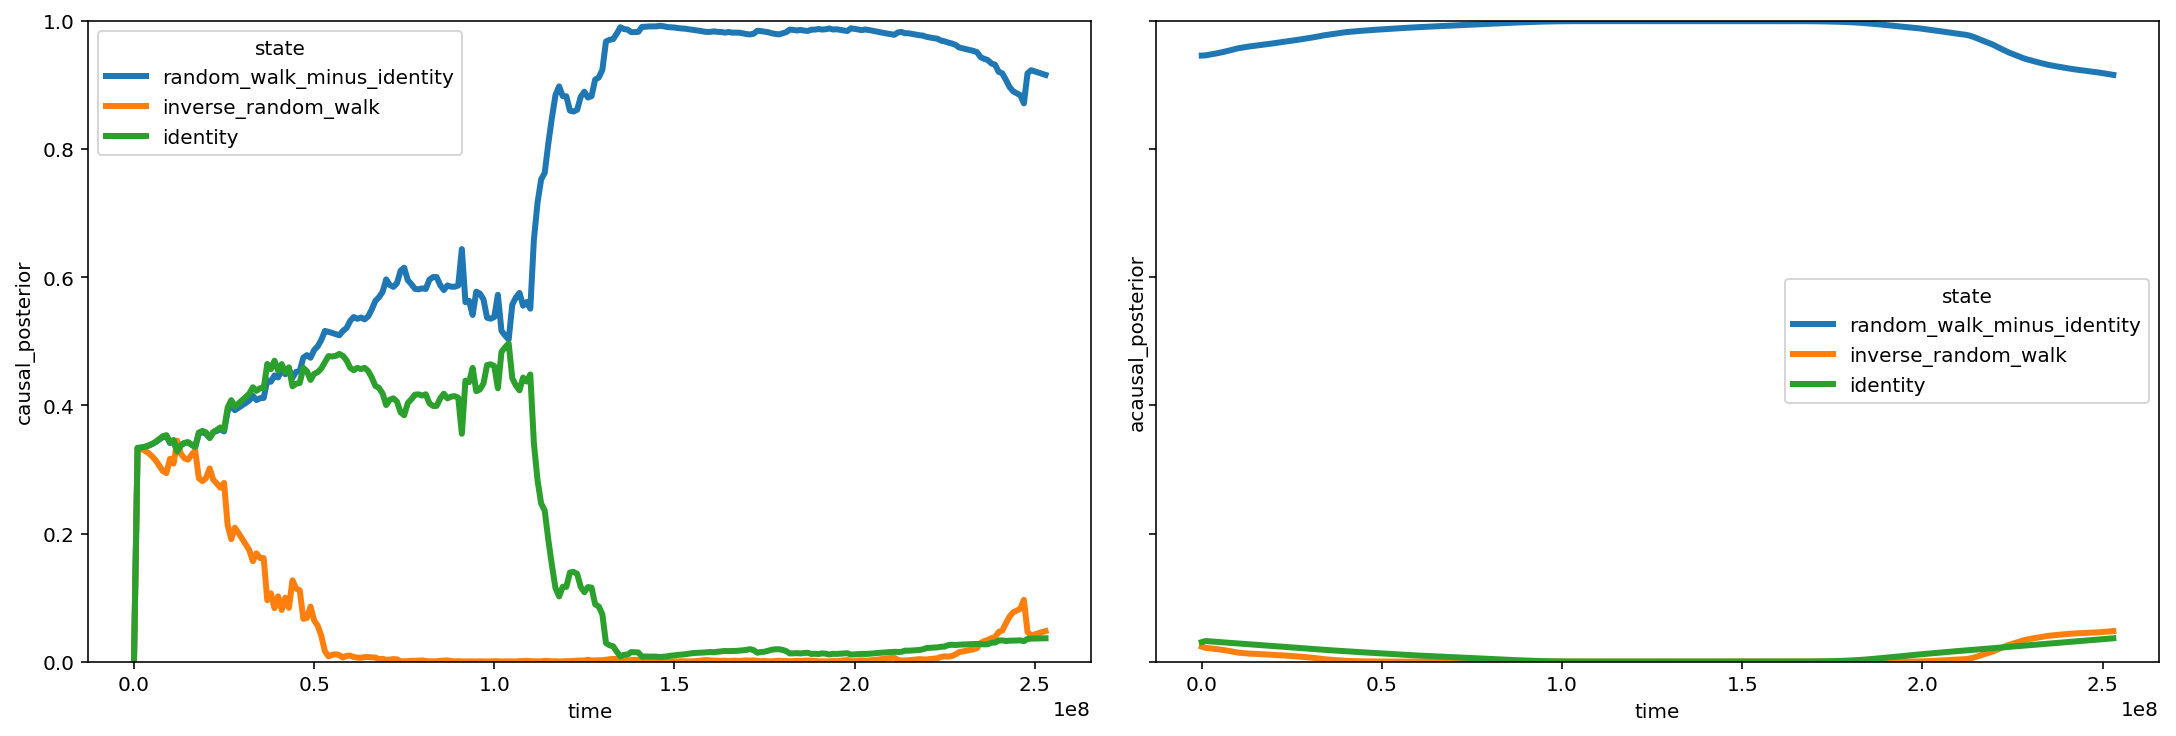

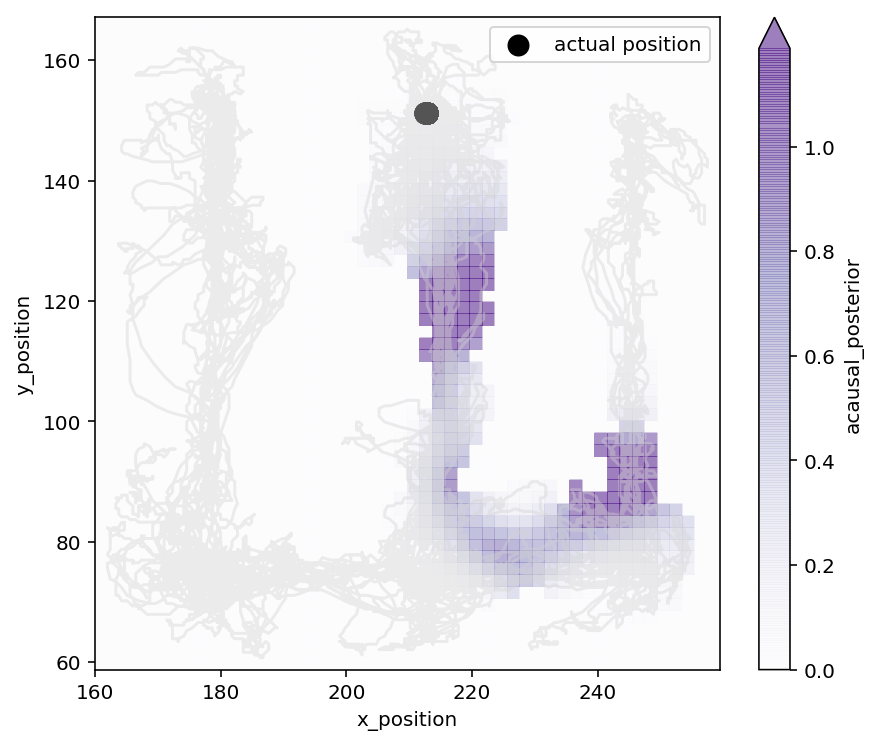

In [201]:
from src.visualization import (
    maximum_a_posteriori_estimate, plot_2D_position_with_color_time)

fig, axes = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=True, sharey=True)
classifier.predict_proba(result).causal_posterior.plot(hue='state', ax=axes[0], linewidth=3)
classifier.predict_proba(result).acausal_posterior.plot(hue='state', ax=axes[1], linewidth=3);
axes[0].set_ylim((0, 1))


fig, ax = plt.subplots(1, 1, figsize=(7, 6))

result.sum(['state', 'time']).acausal_posterior.plot(
    x='x_position', y='y_position', robust=True, cmap='Purples',
    alpha=0.5, vmin=0.0)

ax.plot(position.values[:, 0], position.values[:, 1], color='lightgrey', alpha=0.4, zorder=1)
ax.scatter(ripple_position.loc[ripple_number].values[:, 0],
           ripple_position.loc[ripple_number].values[:, 1], color='black', s=100,
           label='actual position');
ax.legend()

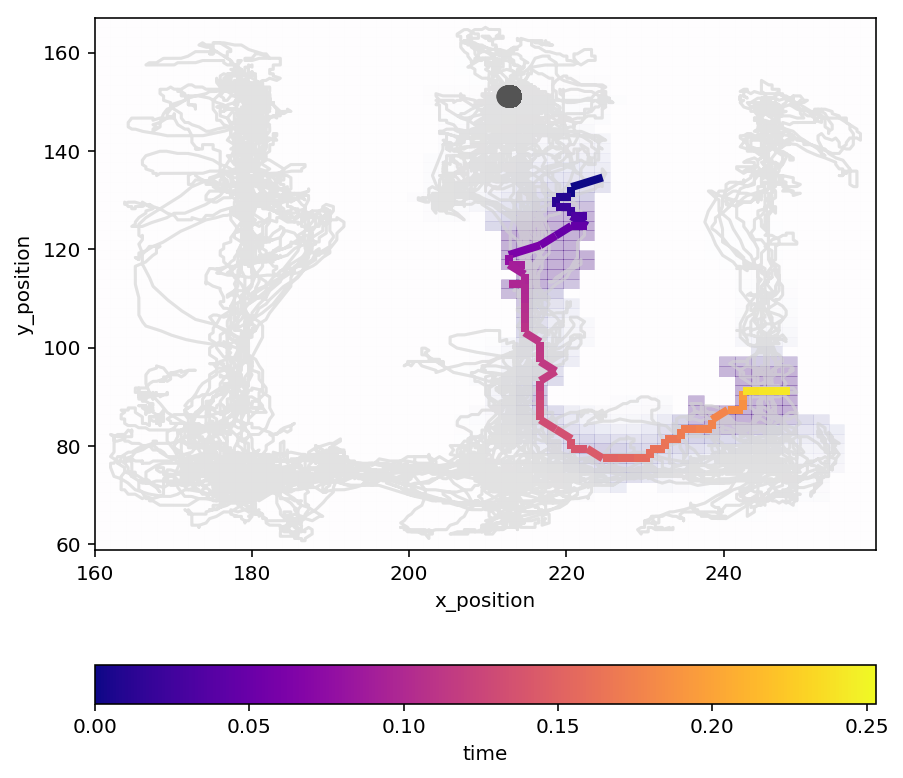

In [32]:
posterior = (result
             .acausal_posterior
             .dropna('time')
             .assign_coords(
                 time=lambda ds: ds.time / np.timedelta64(1, 's'),))
time = posterior.time.values
map_estimate = maximum_a_posteriori_estimate(posterior.sum('state'))

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.plot(position.values[:, 0], position.values[:, 1],
             color='lightgrey', alpha=0.4, zorder=0)
plot_2D_position_with_color_time(
    time, map_estimate, ax=ax)
posterior.sum(['state', 'time']).plot(
    x='x_position', y='y_position', robust=True, cmap='Purples', alpha=0.3,
    ax=ax, add_colorbar=False, zorder=0)
ax.plot(position.values[:, 0], position.values[:, 1], color='lightgrey', alpha=0.4, zorder=1)
ax.scatter(ripple_position.loc[ripple_number].values[:, 0],
           ripple_position.loc[ripple_number].values[:, 1], color='black', s=100,
           label='actual position');


In [ ]:
TRANSITION_TO_CATEGORY = {
    'identity': 'hover',
    'inverse_random_walk': 'fragmented',
    'random_walk_minus_identity': 'continuous',
}

results = []
for ripple_number in data['ripple_times'].index[:3]:
    time_slice = slice(*data['ripple_times'].loc[
        ripple_number, ['start_time', 'end_time']])
    m = data['multiunit'].sel(time=time_slice)
    results.append(classifier.predict(m, m.time - m.time[0]))
results = xr.concat(results, dim=data['ripple_times'].index[:3])
results = results.assign_coords(
    state=lambda ds: ds.state.to_index()
    .map(TRANSITION_TO_CATEGORY))

In [ ]:
results

In [ ]:
from loren_frank_data_processing import reshape_to_segments

spikes = (((data['multiunit'].sum('features') > 0) * 1.0)
          .to_dataframe(name='spikes').unstack())
spikes.columns = data['tetrode_info'].tetrode_id
ripple_spikes = reshape_to_segments(
    spikes, ripple_times)

In [ ]:
from src.analysis import (get_linear_position_order, get_place_field_max,
                          get_replay_info)

PROBABILITY_THRESHOLD = 0.8

ripple_position = reshape_to_segments(
    position, ripple_times)
replay_info = get_replay_info(
    results, ripple_spikes, ripple_position, data['ripple_times'],
    SAMPLING_FREQUENCY, PROBABILITY_THRESHOLD)

In [ ]:
movement_var

In [ ]:
replay_speedup = 2

print(f'std = {np.sqrt(movement_var)} cm/ms')
print(f'std = {1000 * np.sqrt(movement_var) / 100} m/s')
print(f'replay std = {replay_speedup * 1000 * np.sqrt(movement_var) / 100} m/s')

In [ ]:
AVG_REPLAY_SPEED = 20.0 # m/s
replay_speedup = AVG_REPLAY_SPEED / (data['sampling_frequency'] * np.sqrt(movement_var) / 100.0)
replay_speedup

In [ ]:
plt.hist(data['position_info'].speed)
std = np.sqrt(movement_var)
plt.axvline(data['position_info'].speed.mean() + std, color='black', linestyle='--')
plt.axvline(data['position_info'].speed.mean(), color='black')
plt.axvline(data['position_info'].speed.mean() - std, color='black', linestyle='--')

In [ ]:
np.sqrt(np.diag(estimate_movement_var(position.loc[is_training], SAMPLING_FREQUENCY)).max())

In [ ]:
from scipy.stats import multivariate_normal

x = np.arange(-10, 10, 2.0)
var = 2.0
plt.plot(x, multivariate_normal(mean=0, cov=var).pdf(x))
plt.axvline(var, color='black', linestyle='--')
plt.axvline(-var, color='black', linestyle='--')

var = 1.0
plt.plot(x, multivariate_normal(mean=0, cov=var).pdf(x))
plt.axvline(var, color='black', linestyle='--')
plt.axvline(-var, color='black', linestyle='--')

In [203]:
from sklearn.neighbors import KDTree
from sklearn.base import BaseEstimator, DensityMixin
import numba

SQRT_2PI = np.float64(np.sqrt(2.0 * np.pi))

@numba.njit(nogil=True)
def numba_kde(eval_points, samples, sample_inds, bandwidths):
    n_eval_points, n_bandwidths = eval_points.shape
    result = np.zeros((n_eval_points,))
    n_samples = len(samples)

    for i, ind in enumerate(sample_inds):
        for blah in ind:
            product_kernel = 1.0
            for k in range(n_bandwidths):
                bandwidth = bandwidths[k]
                eval_point = eval_points[i, k]
                sample = samples[blah, k]
                product_kernel *= (np.exp(
                    -0.5 * ((eval_point - sample) / bandwidth)**2) /
                    (bandwidth * SQRT_2PI)) / bandwidth
            result[i] += product_kernel
        result[i] /= n_samples

    return result


class KDE(BaseEstimator, DensityMixin):
    def __init__(self, bandwidth=1, n_position_dims=2, n_mark_dims=4):
        self.n_position_dims = n_position_dims
        self.n_mark_dims = n_mark_dims
        self.bandwidth = bandwidth

    def fit(self, X, y=None, sample_weight=None):
        self.training_data = X
        if X.shape[1] == self.n_position_dims:
            self.position_tree_ = KDTree(X)
            self.mark_tree_ = None
        else:
            self.position_tree_ = KDTree(X[:, -self.n_position_dims:])
            self.mark_tree_ = KDTree(X[:, :self.n_mark_dims])
        
        return self

    def score_samples(self, X):
        if X.shape[1] == self.n_position_dims:
            radius = self.bandwidth[-1] * 3
            position_training_inds = self.position_tree_.query_radius(X, radius)
            return np.log(numba_kde(X, self.training_data, position_training_inds.tolist(),
                                    self.bandwidth[-self.n_position_dims:]))
        else:
            radius = self.bandwidth[0] * 3
            mark_training_inds = self.mark_tree_.query_radius(X[:, :self.n_mark_dims], radius)
            position_training_inds = self.position_tree_.query_radius(X[:, self.n_mark_dims:], radius)
            inds = [np.intersect1d(p_i, m_i, assume_unique=True)
                    for m_i, p_i in zip(mark_training_inds, position_training_inds)]
            
            return np.log(numba_kde(X, self.training_data, inds, self.bandwidth))

In [192]:
kde = KDE(bandwidth=np.ones((6,))).fit(X[:, :6])
np.exp(kde.score_samples(X[:, :6]))

array([0.00403144, 0.00403144, 0.00403144])

In [193]:
kde = KDE(bandwidth=np.ones((6,))).fit(X[:, :2])
np.exp(kde.score_samples(X[:, :2]))

array([0.15915494, 0.15915494, 0.15915494])

In [204]:
from replay_trajectory_classification import ClusterlessClassifier
from replay_trajectory_classification.state_transition import estimate_movement_var
from src.parameters import SAMPLING_FREQUENCY
from dask.diagnostics import ProgressBar
from replay_trajectory_classification.misc import NumbaKDE

position = data['position_info'].loc[:, ['x_position', 'y_position']]
is_training = data['position_info'].speed > 4
ripple_times = data['ripple_times'].loc[:, ['start_time', 'end_time']]

movement_var = np.diag(
    estimate_movement_var(position, SAMPLING_FREQUENCY)).max()

model_kwargs = {
    'bandwidth': np.array([24.0, 24.0, 24.0, 24.0, 6.0, 6.0])}
classifier = ClusterlessClassifier(
    place_bin_size=2.0,
    movement_var=1.0,
    replay_speed=1,
    discrete_transition_diag=1-1E-3,
    model=KDE,
    model_kwargs=model_kwargs).fit(
    position, data['multiunit'], is_training=is_training)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting multiunits...


In [195]:
ripple_number = 145

time_slice = slice(data['ripple_times'].loc[ripple_number, 'start_time'],
                   data['ripple_times'].loc[ripple_number, 'end_time'])
m = data['multiunit'].sel(time=time_slice)
result = classifier.predict(m, m.time - m.time[0])

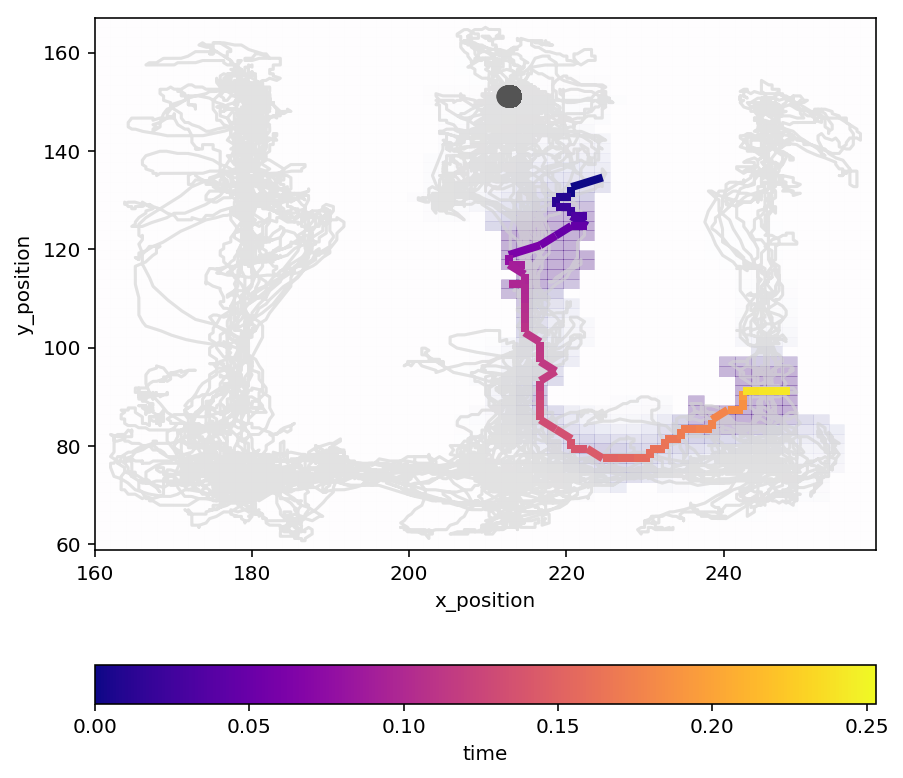

In [196]:
posterior = (result
             .acausal_posterior
             .dropna('time')
             .assign_coords(
                 time=lambda ds: ds.time / np.timedelta64(1, 's'),))
time = posterior.time.values
map_estimate = maximum_a_posteriori_estimate(posterior.sum('state'))

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.plot(position.values[:, 0], position.values[:, 1],
             color='lightgrey', alpha=0.4, zorder=0)
plot_2D_position_with_color_time(
    time, map_estimate, ax=ax)
posterior.sum(['state', 'time']).plot(
    x='x_position', y='y_position', robust=True, cmap='Purples', alpha=0.3,
    ax=ax, add_colorbar=False, zorder=0)
ax.plot(position.values[:, 0], position.values[:, 1], color='lightgrey', alpha=0.4, zorder=1)
ax.scatter(ripple_position.loc[ripple_number].values[:, 0],
           ripple_position.loc[ripple_number].values[:, 1], color='black', s=100,
           label='actual position');


In [205]:
%time classifier.predict(m, m.time - m.time[0])

CPU times: user 6min 42s, sys: 58.2 s, total: 7min 40s
Wall time: 39min 32s


<xarray.Dataset>
Dimensions:            (state: 3, time: 254, x_position: 50, y_position: 55)
Coordinates:
  * time               (time) timedelta64[ns] 00:00:00 ... 00:00:00.253000
  * x_position         (x_position) float64 161.0 163.0 165.0 ... 256.4 258.4
  * y_position         (y_position) float64 59.77 61.73 63.7 ... 164.2 166.1
  * state              (state) <U26 'random_walk_minus_identity' ... 'identity'
Data variables:
    likelihood         (time, state, x_position, y_position) float64 1.0 ... 1.0
    causal_posterior   (time, state, x_position, y_position) float64 0.0 ... 0.0
    acausal_posterior  (time, state, x_position, y_position) float64 0.0 ... 0.0

In [206]:
ripple_number = 8

time_slice = slice(data['ripple_times'].loc[ripple_number, 'start_time'],
                   data['ripple_times'].loc[ripple_number, 'end_time'])
m = data['multiunit'].sel(time=time_slice)
result = classifier.predict(m, m.time - m.time[0])

posterior = (result
             .acausal_posterior
             .dropna('time')
             .assign_coords(
                 time=lambda ds: ds.time / np.timedelta64(1, 's'),))
time = posterior.time.values
map_estimate = maximum_a_posteriori_estimate(posterior.sum('state'))

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.plot(position.values[:, 0], position.values[:, 1],
             color='lightgrey', alpha=0.4, zorder=0)
plot_2D_position_with_color_time(
    time, map_estimate, ax=ax)
posterior.sum(['state', 'time']).plot(
    x='x_position', y='y_position', robust=True, cmap='Purples', alpha=0.3,
    ax=ax, add_colorbar=False, zorder=0)
ax.plot(position.values[:, 0], position.values[:, 1], color='lightgrey', alpha=0.4, zorder=1)
ax.scatter(ripple_position.loc[ripple_number].values[:, 0],
           ripple_position.loc[ripple_number].values[:, 1], color='black', s=100,
           label='actual position');


KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
